# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'timewarp'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3309.222966   281.384549     0.076457     0.000191    46.013120
std       1949.980766    11.293620     0.741707     0.005003    38.320736
min          0.001673   243.393557     0.000000     0.000000     0.000000
25%       1400.118164   273.729032     0.000000     0.000000     1.000000
50%       3569.796796   281.848930     0.000000     0.000000    41.480458
75%       4936.000000   290.388538     0.000000     0.000000    90.000000
max       7216.981273   307.281342    39.612953     0.250000   100.000000


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3244.668912   282.208136     0.086792     0.000233    44.397306
std       1946.247953    12.114907     0.901360     0.006145    39.195308
min 

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 500,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  500
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.19514432603180626 // Train Acc: 0.011405109489051095
Val Loss: 0.15106541518017527 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.019957637936080786 // Train Acc: 0.011405109489051095
Val Loss: 0.022123722564976883 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011270406694630718 // Train Acc: 0.011405109489051095
Val Loss: 0.013312211965539437 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008300442394739302 // Train Acc: 0.011405109489051095
Val Loss: 0.00957849430714679 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00718077064456119 // Train Acc: 0.011405109489051095
Val Loss: 0.008336547635468271 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006874675969559237 // Train Acc: 0.011405109489051095
Val Loss: 0.008013035526827854 // Val Acc: 0.0


c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:26<30:57, 206.39s/it]

Epoch: 1
Train Loss: 0.19444283951468166 // Train Acc: 0.011405109489051095
Val Loss: 0.14876105966900735 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03092825108540863 // Train Acc: 0.011405109489051095
Val Loss: 0.03424732025493594 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013066436159832362 // Train Acc: 0.011405109489051095
Val Loss: 0.014492619207457584 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010378031812975332 // Train Acc: 0.011405109489051095
Val Loss: 0.011162440922549543 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008879619106279863 // Train Acc: 0.011405109489051095
Val Loss: 0.009173057637834811 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007547382377495949 // Train Acc: 0.011405109489051095
Val Loss: 0.007870439796105903 // Val Acc: 0.0


 20%|██        | 2/10 [06:49<27:15, 204.40s/it]

Epoch: 1
Train Loss: 0.1125139510327012 // Train Acc: 0.011405109489051095
Val Loss: 0.10186716070508256 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028762531670721344 // Train Acc: 0.011405109489051095
Val Loss: 0.031957141808508074 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011761490338869448 // Train Acc: 0.011405109489051095
Val Loss: 0.01295426337952342 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009655454082594654 // Train Acc: 0.011405109489051095
Val Loss: 0.010576434330740833 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008752502142417714 // Train Acc: 0.011405109489051095
Val Loss: 0.009546085897668758 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008312160789076048 // Train Acc: 0.011405109489051095
Val Loss: 0.008869320188429864 // Val Acc: 0.0


 30%|███       | 3/10 [07:38<15:34, 133.50s/it]

INFO: Validation loss did not improve in epoch 121
Early stopping after 121 epochs
Epoch: 1
Train Loss: 0.38050110512379093 // Train Acc: 0.02281021897810219
Val Loss: 0.2966071859221248 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04148944489059657 // Train Acc: 0.011405109489051095
Val Loss: 0.04645913855775314 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01584295495617183 // Train Acc: 0.011405109489051095
Val Loss: 0.01814835091285846 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011099087102440642 // Train Acc: 0.011405109489051095
Val Loss: 0.012424292891998501 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009927736213736672 // Train Acc: 0.011405109489051095
Val Loss: 0.010567941090009888 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009183097012335923 // 

 40%|████      | 4/10 [10:00<13:41, 136.88s/it]

INFO: Validation loss did not improve in epoch 350
Early stopping after 350 epochs
Epoch: 1
Train Loss: 0.13850496937078935 // Train Acc: 0.011405109489051095
Val Loss: 0.10503136646002531 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.025416442764120816 // Train Acc: 0.011405109489051095
Val Loss: 0.02802684875752996 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011762768030166626 // Train Acc: 0.011405109489051095
Val Loss: 0.013051592690103194 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009701329165726328 // Train Acc: 0.011405109489051095
Val Loss: 0.01066952062811812 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008629230955100693 // Train Acc: 0.011405109489051095
Val Loss: 0.009771710049415775 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008181525576378756

 50%|█████     | 5/10 [13:23<13:22, 160.57s/it]

Epoch: 1
Train Loss: 0.40206413699762666 // Train Acc: 0.02281021897810219
Val Loss: 0.30276596655740456 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.029202290810644627 // Train Acc: 0.011405109489051095
Val Loss: 0.03194764111300602 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013430579738813812 // Train Acc: 0.011405109489051095
Val Loss: 0.014684373009539045 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010781977205863562 // Train Acc: 0.011405109489051095
Val Loss: 0.011674785137395649 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009172482486137862 // Train Acc: 0.011405109489051095
Val Loss: 0.009662855173433748 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007356049308560136 // Train Acc: 0.011405109489051095
Val Loss: 0.007723684477455476 // Val Acc: 0.0


 60%|██████    | 6/10 [14:29<08:34, 128.63s/it]

INFO: Validation loss did not improve in epoch 165
Early stopping after 165 epochs
Epoch: 1
Train Loss: 0.25214836894989995 // Train Acc: 0.0
Val Loss: 0.1716707065317999 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.019357534623398943 // Train Acc: 0.011405109489051095
Val Loss: 0.020913527607369947 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012552783501599609 // Train Acc: 0.011405109489051095
Val Loss: 0.013809164975742427 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008939857241174165 // Train Acc: 0.011405109489051095
Val Loss: 0.009588632133433266 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007203213042447031 // Train Acc: 0.011405109489051095
Val Loss: 0.007629064617075902 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006950860588988085 // Train Acc: 0

 70%|███████   | 7/10 [15:38<05:26, 108.94s/it]

INFO: Validation loss did not improve in epoch 170
Early stopping after 170 epochs
Epoch: 1
Train Loss: 0.3085200829757717 // Train Acc: 0.02281021897810219
Val Loss: 0.22650683593169293 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02239344591431211 // Train Acc: 0.011405109489051095
Val Loss: 0.02404177324462901 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013501626580450548 // Train Acc: 0.011405109489051095
Val Loss: 0.014643344151623109 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01001690882581021 // Train Acc: 0.011405109489051095
Val Loss: 0.010615235057604663 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008347705960865167 // Train Acc: 0.011405109489051095
Val Loss: 0.00875764385358814 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007764808551908002 // 

 80%|████████  | 8/10 [18:59<04:36, 138.37s/it]

Epoch: 1
Train Loss: 0.17558728970492082 // Train Acc: 0.011405109489051095
Val Loss: 0.13581013934077313 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02193663689736141 // Train Acc: 0.011405109489051095
Val Loss: 0.023407952462816062 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012018039623312788 // Train Acc: 0.011405109489051095
Val Loss: 0.013389834110378562 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009375808040788193 // Train Acc: 0.011405109489051095
Val Loss: 0.010270270710701452 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008018611327627755 // Train Acc: 0.011405109489051095
Val Loss: 0.008610615969005534 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0073410656584008685 // Train Acc: 0.011405109489051095
Val Loss: 0.007675201186965055 // Val Acc: 0.

 90%|█████████ | 9/10 [22:20<02:38, 158.03s/it]

Epoch: 1
Train Loss: 0.1979968344935481 // Train Acc: 0.011405109489051095
Val Loss: 0.12769037515253706 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.031194182289560345 // Train Acc: 0.011405109489051095
Val Loss: 0.03512632282560363 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013740671485030248 // Train Acc: 0.011405109489051095
Val Loss: 0.015561416936928736 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010876962911663917 // Train Acc: 0.011405109489051095
Val Loss: 0.012044355218463084 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009158214586481016 // Train Acc: 0.011405109489051095
Val Loss: 0.009656436600968899 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008049819879335807 // Train Acc: 0.011405109489051095
Val Loss: 0.008425150511731557 // Val Acc: 0.0


100%|██████████| 10/10 [25:42<00:00, 154.20s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.3108779012170284 // Train Acc: 0.0
Val Loss: 0.2078266684304584 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04594364623670981 // Train Acc: 0.014269406392694063
Val Loss: 0.039277892119505185 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016285107342407245 // Train Acc: 0.014269406392694063
Val Loss: 0.014027566987682472 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01246897578739123 // Train Acc: 0.014269406392694063
Val Loss: 0.011050945909863169 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010683255406207145 // Train Acc: 0.014269406392694063
Val Loss: 0.009772335898808458 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00951014838519519 // Train Acc: 0.014269406392694063
Val Loss: 0.009031445825133811 // Val Acc: 0.0
********************

 10%|█         | 1/10 [02:45<24:49, 165.53s/it]

Epoch: 1
Train Loss: 0.18855735072738503 // Train Acc: 0.014269406392694063
Val Loss: 0.12436303010379726 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03838023535703143 // Train Acc: 0.014269406392694063
Val Loss: 0.0325695461678234 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013161199883404763 // Train Acc: 0.014269406392694063
Val Loss: 0.011043269906870344 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011588163531415131 // Train Acc: 0.014269406392694063
Val Loss: 0.009708601092411713 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01070568273343639 // Train Acc: 0.014269406392694063
Val Loss: 0.008920695746994832 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009842822890618145 // Train Acc: 0.014269406392694063
Val Loss: 0.008120867834341797 // Val Acc: 0.0
**

 20%|██        | 2/10 [05:30<22:02, 165.29s/it]

Epoch: 1
Train Loss: 0.16783895911691396 // Train Acc: 0.014269406392694063
Val Loss: 0.10342784906652841 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.029856077518705365 // Train Acc: 0.014269406392694063
Val Loss: 0.025897913121364333 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013416700425013457 // Train Acc: 0.014269406392694063
Val Loss: 0.011751859084787694 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010451577252444713 // Train Acc: 0.014269406392694063
Val Loss: 0.008729364955797791 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008831095554308804 // Train Acc: 0.014269406392694063
Val Loss: 0.007159253586591645 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008056656754103629 // Train Acc: 0.014269406392694063
Val Loss: 0.0063624034339392725 // Val Acc: 0

 30%|███       | 3/10 [08:15<19:16, 165.24s/it]

Epoch: 1
Train Loss: 0.4129165396196385 // Train Acc: 0.028538812785388126
Val Loss: 0.2915367836301977 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.038187662347913064 // Train Acc: 0.014269406392694063
Val Loss: 0.032706445455551146 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01553742895987242 // Train Acc: 0.014269406392694063
Val Loss: 0.012989454898475247 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012358995510656471 // Train Acc: 0.014269406392694063
Val Loss: 0.010060314381156456 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010806130162933544 // Train Acc: 0.014269406392694063
Val Loss: 0.008732281976633451 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009586844257861545 // Train Acc: 0.014269406392694063
Val Loss: 0.0077053358863023195 // Val Acc: 0.0


 40%|████      | 4/10 [11:01<16:32, 165.37s/it]

Epoch: 1
Train Loss: 0.3015042369734479 // Train Acc: 0.028538812785388126
Val Loss: 0.19065366448326546 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.029476174625427756 // Train Acc: 0.014269406392694063
Val Loss: 0.02481182519007813 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014859563377622056 // Train Acc: 0.014269406392694063
Val Loss: 0.01236496068621901 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010576893827988506 // Train Acc: 0.014269406392694063
Val Loss: 0.008644002451646057 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008661653634668944 // Train Acc: 0.014269406392694063
Val Loss: 0.006987622117793018 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007896057090330784 // Train Acc: 0.014269406392694063
Val Loss: 0.006186413062228398 // Val Acc: 0.0
*

 50%|█████     | 5/10 [13:46<13:46, 165.37s/it]

Epoch: 1
Train Loss: 0.2750418603539331 // Train Acc: 0.0
Val Loss: 0.17858771715651858 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0348011981865995 // Train Acc: 0.014269406392694063
Val Loss: 0.029655090262266724 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015066201785859996 // Train Acc: 0.014269406392694063
Val Loss: 0.01211197329685092 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011572421999376047 // Train Acc: 0.014269406392694063
Val Loss: 0.009267703947526488 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009575686192663056 // Train Acc: 0.014269406392694063
Val Loss: 0.007694287035106258 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00828530407802002 // Train Acc: 0.014269406392694063
Val Loss: 0.006722172815352678 // Val Acc: 0.0
********************

 60%|██████    | 6/10 [16:32<11:01, 165.43s/it]

Epoch: 1
Train Loss: 0.13658656839060185 // Train Acc: 0.014269406392694063
Val Loss: 0.08445062085308812 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.034470520390529336 // Train Acc: 0.014269406392694063
Val Loss: 0.02945856973528862 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01509079248612517 // Train Acc: 0.014269406392694063
Val Loss: 0.01378906394608996 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011883957604409863 // Train Acc: 0.014269406392694063
Val Loss: 0.01027781938795339 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009775561206659397 // Train Acc: 0.014269406392694063
Val Loss: 0.008201483497396111 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008592970321618328 // Train Acc: 0.014269406392694063
Val Loss: 0.006965882348066026 // Val Acc: 0.0
**

 70%|███████   | 7/10 [19:17<08:16, 165.34s/it]

Epoch: 1
Train Loss: 0.1131856049066537 // Train Acc: 0.014269406392694063
Val Loss: 0.07826782099225305 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.033485493188953566 // Train Acc: 0.014269406392694063
Val Loss: 0.028395752541043543 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014016230303058444 // Train Acc: 0.014269406392694063
Val Loss: 0.011870873186059974 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010735411255952124 // Train Acc: 0.014269406392694063
Val Loss: 0.009005825335837223 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009283753014679947 // Train Acc: 0.014269406392694063
Val Loss: 0.007962063103067603 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008754081283610944 // Train Acc: 0.014269406392694063
Val Loss: 0.007404615789313208 // Val Acc: 0.0

 80%|████████  | 8/10 [22:03<05:31, 165.53s/it]

Epoch: 1
Train Loss: 0.1820203378779567 // Train Acc: 0.014269406392694063
Val Loss: 0.11619521818039093 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04132722441498275 // Train Acc: 0.014269406392694063
Val Loss: 0.03593153404918584 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014733450429845755 // Train Acc: 0.014269406392694063
Val Loss: 0.012732611808248542 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01210871977533839 // Train Acc: 0.014269406392694063
Val Loss: 0.0103118673263287 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010762131164811518 // Train Acc: 0.014269406392694063
Val Loss: 0.009040223028172147 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009928585920529653 // Train Acc: 0.014269406392694063
Val Loss: 0.008241960173472762 // Val Acc: 0.0
****

 90%|█████████ | 9/10 [24:48<02:45, 165.50s/it]

Epoch: 1
Train Loss: 0.12269402352336063 // Train Acc: 0.014269406392694063
Val Loss: 0.07997866134074601 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0225257003343915 // Train Acc: 0.014269406392694063
Val Loss: 0.02044856875118884 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014338529857989724 // Train Acc: 0.014269406392694063
Val Loss: 0.012441702229394154 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011733438954667346 // Train Acc: 0.014269406392694063
Val Loss: 0.009988949346271429 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009869949739600732 // Train Acc: 0.014269406392694063
Val Loss: 0.008692871305075558 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008631850469466214 // Train Acc: 0.014269406392694063
Val Loss: 0.007635346664623781 // Val Acc: 0.0
*

100%|██████████| 10/10 [27:33<00:00, 165.39s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.18135045479013495 // Train Acc: 0.014269406392694063
Val Loss: 0.10744895647195253 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03846409230080505 // Train Acc: 0.014269406392694063
Val Loss: 0.03842370262877508 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014993830808315034 // Train Acc: 0.014269406392694063
Val Loss: 0.017503072727810254 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011114911281516494 // Train Acc: 0.014269406392694063
Val Loss: 0.012715638361193916 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009561426070179646 // Train Acc: 0.014269406392694063
Val Loss: 0.010509745395657692 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008563405242626295 // Train Acc: 0.014269406392694063
Val Loss: 0.009071539992212573 // Val Acc: 0.0


 10%|█         | 1/10 [01:12<10:54, 72.70s/it]

INFO: Validation loss did not improve in epoch 222
Early stopping after 222 epochs
Epoch: 1
Train Loss: 0.24469267650077878 // Train Acc: 0.014269406392694063
Val Loss: 0.14625703929500147 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.031344768549762154 // Train Acc: 0.014269406392694063
Val Loss: 0.03252912351692265 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014106385313882386 // Train Acc: 0.014269406392694063
Val Loss: 0.016295352937992325 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010405494398267335 // Train Acc: 0.014269406392694063
Val Loss: 0.011761007301340049 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008877694760672492 // Train Acc: 0.014269406392694063
Val Loss: 0.009651546112515709 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00782567640893016

 20%|██        | 2/10 [03:57<16:53, 126.66s/it]

Epoch: 1
Train Loss: 0.3239037181892896 // Train Acc: 0.0
Val Loss: 0.20936266048388047 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04880127978838606 // Train Acc: 0.014269406392694063
Val Loss: 0.04539666043763811 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01730668642154159 // Train Acc: 0.014269406392694063
Val Loss: 0.0191828797317364 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011134889100935548 // Train Acc: 0.014269406392694063
Val Loss: 0.012837904314933852 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009954460011609111 // Train Acc: 0.014269406392694063
Val Loss: 0.011039867480708794 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00923115402097563 // Train Acc: 0.014269406392694063
Val Loss: 0.009955182544548403 // Val Acc: 0.0
**********************

 30%|███       | 3/10 [06:41<16:47, 143.86s/it]

Epoch: 1
Train Loss: 0.09891324908766028 // Train Acc: 0.014269406392694063
Val Loss: 0.06488844257864085 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03045465048300485 // Train Acc: 0.014269406392694063
Val Loss: 0.03147966827858578 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013541284313884704 // Train Acc: 0.014269406392694063
Val Loss: 0.015029855131764304 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010305178785201196 // Train Acc: 0.014269406392694063
Val Loss: 0.011404256962917067 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008649789575130155 // Train Acc: 0.014269406392694063
Val Loss: 0.009273136720399965 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007606564404216454 // Train Acc: 0.014269406392694063
Val Loss: 0.007841862160289152 // Val Acc: 0.0


 40%|████      | 4/10 [07:26<10:29, 104.97s/it]

INFO: Validation loss did not improve in epoch 138
Early stopping after 138 epochs
Epoch: 1
Train Loss: 0.2301961523076715 // Train Acc: 0.014269406392694063
Val Loss: 0.13538469245487994 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.030473041405038034 // Train Acc: 0.014269406392694063
Val Loss: 0.03166199446740475 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014082005584493415 // Train Acc: 0.014269406392694063
Val Loss: 0.015382199124856428 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010651064835984226 // Train Acc: 0.014269406392694063
Val Loss: 0.011774520241570744 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00881294424716834 // Train Acc: 0.014269406392694063
Val Loss: 0.00948303380600092 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007627276849500265 /

 50%|█████     | 5/10 [09:48<09:51, 118.26s/it]

INFO: Validation loss did not improve in epoch 431
Early stopping after 431 epochs
Epoch: 1
Train Loss: 0.561348966335597 // Train Acc: 0.014269406392694063
Val Loss: 0.3472111945802515 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.052270513100200866 // Train Acc: 0.014269406392694063
Val Loss: 0.0482811380516399 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.023358146750397945 // Train Acc: 0.014269406392694063
Val Loss: 0.025108197822489523 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012746016880322978 // Train Acc: 0.014269406392694063
Val Loss: 0.013950360227714885 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010496768537221994 // Train Acc: 0.014269406392694063
Val Loss: 0.01172248651696877 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009194641083279055 // 

 60%|██████    | 6/10 [11:36<07:38, 114.60s/it]

INFO: Validation loss did not improve in epoch 327
Early stopping after 327 epochs
Epoch: 1
Train Loss: 0.1789396186465542 // Train Acc: 0.014269406392694063
Val Loss: 0.10577878982506016 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03693121173057586 // Train Acc: 0.014269406392694063
Val Loss: 0.03648820448328148 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01358930312855101 // Train Acc: 0.014269406392694063
Val Loss: 0.014836736260489983 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010302712004334075 // Train Acc: 0.014269406392694063
Val Loss: 0.011457852720790966 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00898503768895689 // Train Acc: 0.014269406392694063
Val Loss: 0.009833626182411204 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008003671334489763 //

 70%|███████   | 7/10 [14:20<06:32, 130.81s/it]

Epoch: 1
Train Loss: 0.3419538167513669 // Train Acc: 0.0
Val Loss: 0.2165659641677683 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.036708030428686374 // Train Acc: 0.014269406392694063
Val Loss: 0.03549213893711567 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013691723749113852 // Train Acc: 0.014269406392694063
Val Loss: 0.01546706146645275 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010637584618679736 // Train Acc: 0.014269406392694063
Val Loss: 0.011820875612002882 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009779657974794558 // Train Acc: 0.014269406392694063
Val Loss: 0.0105648128146475 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00925321301570817 // Train Acc: 0.014269406392694063
Val Loss: 0.009843417511067607 // Val Acc: 0.0
**********************

 80%|████████  | 8/10 [16:59<04:39, 139.88s/it]

INFO: Validation loss did not improve in epoch 483
Early stopping after 483 epochs
Epoch: 1
Train Loss: 0.18320103679447686 // Train Acc: 0.014269406392694063
Val Loss: 0.1106382606043057 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04556296046261918 // Train Acc: 0.014269406392694063
Val Loss: 0.04091778390786865 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016748478472154146 // Train Acc: 0.014269406392694063
Val Loss: 0.01839681350710717 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010948920208236764 // Train Acc: 0.014269406392694063
Val Loss: 0.012384497611360117 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009505523970992767 // Train Acc: 0.014269406392694063
Val Loss: 0.010502936267717318 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008855501670639145 /

 90%|█████████ | 9/10 [19:43<02:27, 147.51s/it]

Epoch: 1
Train Loss: 0.183717803808448 // Train Acc: 0.014269406392694063
Val Loss: 0.11589062986048786 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03413972064223328 // Train Acc: 0.014269406392694063
Val Loss: 0.03499303097752007 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014899609602996272 // Train Acc: 0.014269406392694063
Val Loss: 0.016251815482974052 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010998188058705363 // Train Acc: 0.014269406392694063
Val Loss: 0.012164282002909617 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009039130903085158 // Train Acc: 0.014269406392694063
Val Loss: 0.009717252998697487 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007660893302359809 // Train Acc: 0.014269406392694063
Val Loss: 0.007887518134984103 // Val Acc: 0.0
**

100%|██████████| 10/10 [22:28<00:00, 134.82s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.2109754094224035 // Train Acc: 0.011425959780621572
Val Loss: 0.08643086440861225 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01260317189570421 // Train Acc: 0.005712979890310786
Val Loss: 0.01409763763384784 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008740951894249144 // Train Acc: 0.005712979890310786
Val Loss: 0.009869303184506647 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007608412842009169 // Train Acc: 0.005712979890310786
Val Loss: 0.008504479568835129 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.006907016770055235 // Train Acc: 0.005712979890310786
Val Loss: 0.0075484727344968736 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006593078354990129 // Train Acc: 0.005712979890310786
Val Loss: 0.007068496443988646 // Val Acc: 0.0


 10%|█         | 1/10 [06:27<58:10, 387.85s/it]

INFO: Validation loss did not improve in epoch 496
Early stopping after 496 epochs
Epoch: 1
Train Loss: 0.20661666542223536 // Train Acc: 0.011425959780621572
Val Loss: 0.06895603529889793 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01214582639426279 // Train Acc: 0.005712979890310786
Val Loss: 0.013863300887511714 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009275520446844794 // Train Acc: 0.005712979890310786
Val Loss: 0.01041423118508914 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007844413490785062 // Train Acc: 0.005712979890310786
Val Loss: 0.008348291335791787 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.006893454283544831 // Train Acc: 0.005712979890310786
Val Loss: 0.00723319048719371 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006498092743843731 

 20%|██        | 2/10 [11:43<46:02, 345.32s/it]

INFO: Validation loss did not improve in epoch 403
Early stopping after 403 epochs
Epoch: 1
Train Loss: 0.11148139503758939 // Train Acc: 0.005712979890310786
Val Loss: 0.08112404166775591 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01155854216342625 // Train Acc: 0.005712979890310786
Val Loss: 0.013015885460738312 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008955036808644682 // Train Acc: 0.005712979890310786
Val Loss: 0.00986938935238868 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00775932982761687 // Train Acc: 0.005712979890310786
Val Loss: 0.008264981446486405 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0068557999069462795 // Train Acc: 0.005712979890310786
Val Loss: 0.00714424647294971 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006544649385816504 

 30%|███       | 3/10 [18:14<42:44, 366.41s/it]

Epoch: 1
Train Loss: 0.20121420136017817 // Train Acc: 0.005712979890310786
Val Loss: 0.09060780063052387 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012165155530765899 // Train Acc: 0.005712979890310786
Val Loss: 0.013754912042606841 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0086907617803331 // Train Acc: 0.005712979890310786
Val Loss: 0.009829904541701955 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007914038305373019 // Train Acc: 0.005712979890310786
Val Loss: 0.008558525916134171 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007341208946846436 // Train Acc: 0.005712979890310786
Val Loss: 0.00797474873594611 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006901233301985791 // Train Acc: 0.005712979890310786
Val Loss: 0.007516037255032536 // Val Acc: 0.0
*

 40%|████      | 4/10 [20:09<26:43, 267.18s/it]

INFO: Validation loss did not improve in epoch 147
Early stopping after 147 epochs
Epoch: 1
Train Loss: 0.21552479944074393 // Train Acc: 0.011425959780621572
Val Loss: 0.08045639349695514 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013145117457126909 // Train Acc: 0.005712979890310786
Val Loss: 0.01485878206542967 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00843361641047948 // Train Acc: 0.005712979890310786
Val Loss: 0.008782778085921617 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007601940555361158 // Train Acc: 0.005712979890310786
Val Loss: 0.007559588199536151 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007058087028059691 // Train Acc: 0.005712979890310786
Val Loss: 0.007228227133643539 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006683213971904266

 50%|█████     | 5/10 [25:23<23:39, 283.83s/it]

INFO: Validation loss did not improve in epoch 401
Early stopping after 401 epochs
Epoch: 1
Train Loss: 0.15060874768166754 // Train Acc: 0.005712979890310786
Val Loss: 0.08164265981930144 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012619348478689108 // Train Acc: 0.005712979890310786
Val Loss: 0.014239136218641172 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008546203488670885 // Train Acc: 0.005712979890310786
Val Loss: 0.009191469125011387 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007544834212096957 // Train Acc: 0.005712979890310786
Val Loss: 0.007760639747549944 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007185219983073118 // Train Acc: 0.005712979890310786
Val Loss: 0.0075632502900107815 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006720675595908

 60%|██████    | 6/10 [27:25<15:16, 229.02s/it]

INFO: Validation loss did not improve in epoch 157
Early stopping after 157 epochs
Epoch: 1
Train Loss: 0.20180268789993996 // Train Acc: 0.011425959780621572
Val Loss: 0.07305747747202129 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011696114082343135 // Train Acc: 0.005712979890310786
Val Loss: 0.013584914541912867 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009355982361081306 // Train Acc: 0.005712979890310786
Val Loss: 0.010444823104669066 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007972293666054637 // Train Acc: 0.005712979890310786
Val Loss: 0.00836676559137071 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007400076397076604 // Train Acc: 0.005712979890310786
Val Loss: 0.007603088489678853 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00711384959431864

 70%|███████   | 7/10 [30:50<11:03, 221.03s/it]

INFO: Validation loss did not improve in epoch 262
Early stopping after 262 epochs
Epoch: 1
Train Loss: 0.1447402506954355 // Train Acc: 0.005712979890310786
Val Loss: 0.07585170207654729 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012211450706985209 // Train Acc: 0.005712979890310786
Val Loss: 0.013793835861553602 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00868066997029793 // Train Acc: 0.005712979890310786
Val Loss: 0.009743347038131426 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007431037987389141 // Train Acc: 0.005712979890310786
Val Loss: 0.008346201078144504 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.006688303636047322 // Train Acc: 0.005712979890310786
Val Loss: 0.007179918757174164 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00651103929505629 

 80%|████████  | 8/10 [33:03<06:25, 192.98s/it]

INFO: Validation loss did not improve in epoch 169
Early stopping after 169 epochs
Epoch: 1
Train Loss: 0.14936456540037607 // Train Acc: 0.005712979890310786
Val Loss: 0.06818425063701238 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013110746979207768 // Train Acc: 0.005712979890310786
Val Loss: 0.015041958184584099 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008424495774463 // Train Acc: 0.005712979890310786
Val Loss: 0.00913309067597284 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007568049244742272 // Train Acc: 0.005712979890310786
Val Loss: 0.007682639639824629 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007132868505058763 // Train Acc: 0.005712979890310786
Val Loss: 0.007213993737583651 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006767693086847802 /

 90%|█████████ | 9/10 [34:41<02:43, 163.25s/it]

INFO: Validation loss did not improve in epoch 125
Early stopping after 125 epochs
Epoch: 1
Train Loss: 0.10098435943588696 // Train Acc: 0.005712979890310786
Val Loss: 0.07373984300476663 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01290717536870431 // Train Acc: 0.005712979890310786
Val Loss: 0.014770186136421911 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008608473994036187 // Train Acc: 0.005712979890310786
Val Loss: 0.009549215319566429 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00713582635075884 // Train Acc: 0.005712979890310786
Val Loss: 0.007146933526896378 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00670581865418103 // Train Acc: 0.005712979890310786
Val Loss: 0.006589833150535603 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006510467949487018 

100%|██████████| 10/10 [41:12<00:00, 247.20s/it]


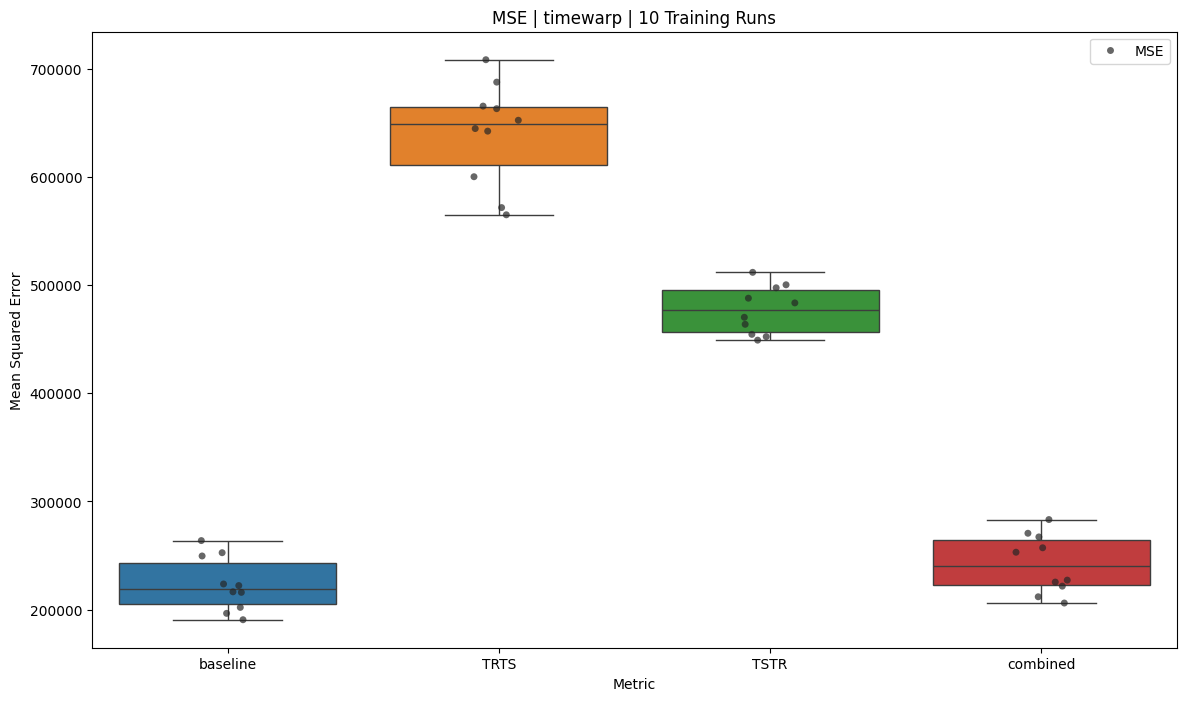

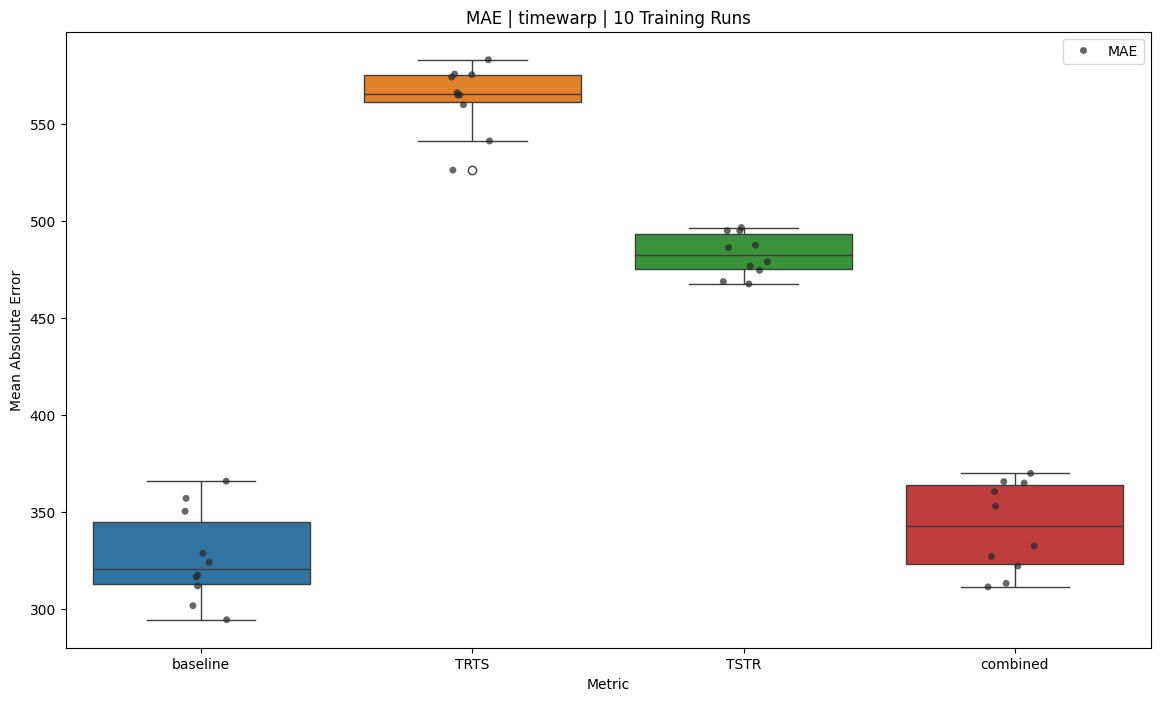

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [9]:
0.2*1e06

200000.0